In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow as tf

In [3]:
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [4]:
!pip install -q transformers tensorflow_datasets

     |████████████████████████████████| 4.2 MB 5.3 MB/s 
     |████████████████████████████████| 84 kB 4.0 MB/s 
     |████████████████████████████████| 6.6 MB 47.5 MB/s 
     |████████████████████████████████| 596 kB 43.5 MB/s 


In [5]:
from transformers import BertTokenizer
from transformers import TFBertForSequenceClassification

In [6]:
!nvidia-smi

Sun May 15 14:08:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W /  70W |    266MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Loading the IMDb dataset from `tensorflow_datasets` 



In [7]:
(ds_train, ds_test), ds_info = tfds.load('imdb_reviews', 
          split = (tfds.Split.TRAIN, tfds.Split.TEST),
          as_supervised=True,
          with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteYW62MS/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteYW62MS/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteYW62MS/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [8]:
for review, label in tfds.as_numpy(ds_train.take(5)):
    print('review', review.decode()[0:50], label)

review This was an absolutely terrible movie. Don't be lu 0
review I have been known to fall asleep during films, but 0
review Mann photographs the Alberta Rocky Mountains in a  0
review This is the kind of film for a snowy Sunday aftern 1
review As others have mentioned, all the women that go nu 1


Tokenization

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Encoding Dataset - Encoding training and test data.

In [19]:
max_length = 100
batch_size = 16
learning_rate = 2e-5
number_of_epochs = 3

In [20]:
def convert_example_to_feature(review):
  return tokenizer.encode_plus(review, 
                add_special_tokens = True, # add [CLS], [SEP]
                max_length = max_length, # max length of the text that can go to BERT
                pad_to_max_length = True, # add [PAD] tokens
                return_attention_mask = True, # add attention mask to not focus on pad tokens
              )

In [21]:
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }, label

def encode_examples(ds, limit=-1):
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []

  if (limit > 0):
      ds = ds.take(limit)
    
  for review, label in tfds.as_numpy(ds):

    bert_input = convert_example_to_feature(review.decode())
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([label])

  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)


Using `encode_examples` to convert train and test dataset.

In [22]:
train_num = 5000
ds_train_encoded = encode_examples(ds_train,train_num).shuffle(10000).batch(batch_size)
ds_val_encoded = encode_examples(ds_train.skip(train_num)).shuffle(10000).batch(batch_size)

ds_test_encoded = encode_examples(ds_test).batch(batch_size)


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Model Initialization - using the Tensorflow model from transformer model importing from the `from_pretrained`

In [23]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
bert_history = model.fit(ds_train_encoded, epochs=number_of_epochs, validation_data=ds_val_encoded)

Epoch 1/3
313/313 [==============================] - 269s 817ms/step - loss: 0.4693 - accuracy: 0.7760 - val_loss: 0.3547 - val_accuracy: 0.8446
Epoch 2/3
313/313 [==============================] - 258s 826ms/step - loss: 0.2785 - accuracy: 0.8902 - val_loss: 0.3446 - val_accuracy: 0.8509
Epoch 3/3
313/313 [==============================] - 259s 830ms/step - loss: 0.1421 - accuracy: 0.9518 - val_loss: 0.4065 - val_accuracy: 0.8518


In [25]:
model.evaluate(ds_test_encoded)

1563/1563 [==============================] - 189s 121ms/step - loss: 0.4084 - accuracy: 0.8476


[0.4084148108959198, 0.847599983215332]

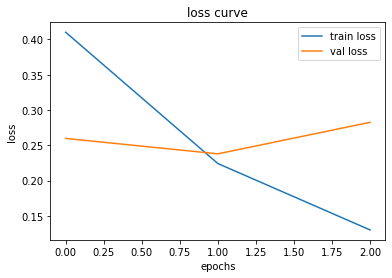

In [18]:
import matplotlib.pyplot as plt
plt.plot(bert_history.history['loss'],label='train loss')
plt.plot(bert_history.history['val_loss'],label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss curve')
plt.legend()
plt.show()